In [178]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
np.random.seed(91828)
import seaborn as sns

In [179]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

In [242]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
#np.random.seed(9182839)
np.random.seed(912841)
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

data = pd.read_csv('processed_data/train_norm_corr').reset_index(drop=True)
data = data.sample(frac=1).reset_index(drop=True)
#x =  data.drop(columns=['class' , 'src_n' ,'src_id' ,'significance'])
x = data.copy().reset_index(drop=True)
y = data['class'].reset_index(drop=True)
x_train , x_test , y_train , y_test = train_test_split(x,y , test_size=0.2 , stratify=y)
id_train = x_train['src_id'].reset_index(drop=True)
id_test = x_test['src_id'].reset_index(drop=True)
n_train = x_train['src_n'].reset_index(drop=True)
n_test = x_test['src_n'].reset_index(drop=True)
y_train_s = x_train['class'].reset_index(drop=True)
y_test_s = x_test['class'].reset_index(drop=True)
x_train = x_train.drop(columns=[ 'index', 'class' , 'src_n' ,'src_id' ,'significance' ,  'var_inter_index' , 'var_inter_prob' , 'var_inter_sigma']).reset_index(drop=True)
x_test = x_test.drop(columns=[ 'index', 'class' , 'src_n' ,'src_id' ,'significance',  'var_inter_index' , 'var_inter_prob' , 'var_inter_sigma']).reset_index(drop=True)

clf = RandomForestClassifier(n_estimators=300 ,random_state=1)
clf.fit(x_train, y_train)
test_score = clf.score(x_test , y_test)
train_score =clf.score(x_train , y_train)
print(train_score)
print(test_score)


import pickle
with open('models/sklearn_rf', 'wb') as f:
    pickle.dump(clf, f)




1.0
0.9130434782608695


In [243]:
import pickle
with open('models/sklearn_rf', 'rb') as f:
    clf = pickle.load(f)

In [244]:
test_score = clf.score(x_test , y_test)
print(test_score)

0.9130434782608695


In [245]:
cf = confusion_matrix(y_test , clf.predict(x_test))
print(cf)

[[28  4]
 [ 4 56]]


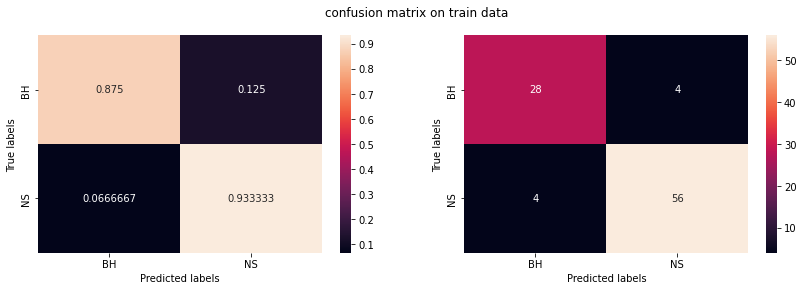

In [246]:
c = np.asarray([[ci /sum(c_row) for ci in c_row] for c_row in cf])
fig , ax = plt.subplots(nrows=1 , ncols=2 , figsize=(14,4)) 
#ax = 
sns.heatmap(c, annot=True, fmt='g', ax=ax[0]);  #annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cf, annot=True, fmt='g', ax=ax[1]); 
# labels, title and ticks
for a in ax:
    a.set_xlabel('Predicted labels')
    a.set_ylabel('True labels')
    #ax[0].set_title('Confusion Matrix Test Data'); 
    a.xaxis.set_ticklabels([ 'BH' , 'NS' ]) 
    a.yaxis.set_ticklabels(['BH', 'NS'])
plt.suptitle('confusion matrix on train data')
#plt.savefig('pred_result/plots/cf_ns_bh_train.jpg')
plt.show()
plt.close()

## Feature Importance

In [247]:
feat_imp = clf.feature_importances_
feat_names = x_train.columns.to_list()
feat = pd.DataFrame()
feat.insert( 0 , 'feat_name' , feat_names)
feat.insert(1 , 'feat_imp' , feat_imp)
feat = feat.sort_values(by = 'feat_imp' , ascending=False).reset_index(drop=True)
feat_names_sorted = feat['feat_name']
display(feat)
feat.to_csv('result/feat_imp.csv')

,feat_name,feat_imp
0,var_inter_index,0.057503
1,var_inter_prob,0.055651
2,photflux_aper_u,0.054075
3,photflux_aper_hilim_u,0.036544
4,flux_aper_u,0.032877
...,...,...
87,hard_ms_hilim,0.003776
88,flux_aper_lolim,0.003628
89,hard_hm,0.003463
90,flux_aper_hilim,0.003436


## Prepare result for analysis

In [229]:
def create_res_data(x , y , id , n , cl_type):
    pred = clf.predict(x)
    pred_prob = clf.predict_proba(x)
    pred_prob = [np.amax(pi) for pi in pred_prob]

    res =  x[feat_names_sorted].copy().reset_index(drop=True)
    res.insert(0 , 'clf_type' , [cl_type]*len(res))
    res.insert(0 , 'src_id' , id)
    res.insert(1, 'src_n' , n)
    res.insert(2 , 'true_class' , y)
    res.insert(3 ,'pred_class' , pred)
    res.insert(4 , 'pred_prob' , pred_prob)
    truth = []
    th_class = [] 
    is_ok = [] 
    for tc , pc , pp in zip(res['true_class'] , res['pred_class'] , res['pred_prob']):
        if(tc==pc): is_ok.append(1)
        else: is_ok.append(0)
        if(pp > 0.80):
            th_class.append(pc)
            if(tc==pc):
                truth.append(1)
            else: truth.append(0)
        else :
            truth.append(2)
            th_class.append('X')
    res.insert(5 , 'th_class' , th_class )
    res.insert(6 , 'truth' , truth)
    res.insert(6 , 'is_ok' , is_ok)
    display(res)
    return res

train_res = create_res_data(x_train , y_train_s , id_train , n_train , cl_type='train')
test_res = create_res_data(x_test , y_test_s , id_test , n_test , cl_type='test')
train_res.to_csv('result/train_res_rf.csv')
test_res.to_csv('result/test_res_rf.csv')

,src_id,src_n,true_class,pred_class,pred_prob,th_class,is_ok,truth,clf_type,photflux_aper_u,...,photflux_aper_hilim_b,hard_hm_hilim,flux_aper_lolim_b,photflux_aper_b,photflux_aper_lolim,bb_nh,hard_hm,flux_aper_lolim,powlaw_gamma,photflux_aper_lolim_b
0,NS0070,SAXWFC J1747.0-2853.,NS,NS,0.966667,NS,1,1,train,0.454142,...,0.253478,1.000000,0.380396,0.252355,0.431973,0.897599,1.000000,0.511236,0.009229,0.314111
1,BH0027,J1745-2900,BH,BH,0.950000,BH,1,1,train,0.367202,...,0.466085,0.964929,0.580562,0.477160,0.596582,1.009271,0.929358,0.639344,0.037054,0.547778
2,NS0044,XMMU J004245.2+41172,NS,NS,0.956667,NS,1,1,train,0.702007,...,0.455047,0.908031,0.444719,0.439915,0.505784,1.176750,0.750600,0.516083,0.082195,0.459414
3,BH0012,XTE J1859+226,BH,BH,0.893333,BH,1,1,train,0.184767,...,0.292384,0.739246,0.278974,0.295648,0.422839,0.952592,0.563138,0.382742,0.216106,0.367292
4,BH0027,J1745-2900,BH,BH,0.946667,BH,1,1,train,0.530266,...,0.418620,1.000000,0.426482,0.409198,0.504471,1.076799,1.000000,0.508944,0.009229,0.446111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,BH0004,GRO J1655-40,BH,BH,0.843333,BH,1,1,train,0.301962,...,0.630006,0.685633,0.727359,0.644339,0.733422,0.057491,0.663748,0.778682,0.329229,0.699713
364,BH0027,J1745-2900,BH,BH,0.953333,BH,1,1,train,0.478229,...,0.450741,1.000000,0.517013,0.442100,0.533737,1.313827,1.000000,0.582533,0.009229,0.480460
365,NS0066,SAXWFC J1734.2-2605.,NS,NS,0.913333,NS,1,1,train,0.235388,...,0.208601,0.240252,0.408308,0.207696,0.352654,1.313827,0.000000,0.296095,0.611997,0.269758
366,NS0046,XMMU J004245.2+41172,NS,NS,0.870000,NS,1,1,train,0.188034,...,0.187644,1.000000,0.114168,0.169183,0.133895,0.952056,0.894387,0.200262,0.009229,0.065302


,src_id,src_n,true_class,pred_class,pred_prob,th_class,is_ok,truth,clf_type,photflux_aper_u,...,photflux_aper_hilim_b,hard_hm_hilim,flux_aper_lolim_b,photflux_aper_b,photflux_aper_lolim,bb_nh,hard_hm,flux_aper_lolim,powlaw_gamma,photflux_aper_lolim_b
0,BH0018,CXOU J100514.2-07423,BH,BH,0.996667,BH,1,1,test,0.217169,...,0.296939,0.460638,0.366577,0.324246,0.532616,0.778926,0.381229,0.473243,0.437148,0.429699
1,NS0044,XMMU J004245.2+41172,NS,NS,1.000000,NS,1,1,test,0.760399,...,0.710487,0.662481,0.754366,0.713842,0.775689,0.903133,0.596858,0.783056,0.277010,0.750725
2,BH0019,CXOU J100515.4-07425,BH,BH,0.533333,X,1,2,test,0.270776,...,0.370732,0.367981,0.420599,0.388549,0.530804,1.022678,0.281269,0.499156,0.510660,0.476504
3,NS0054,BW ANT,NS,BH,0.576667,X,0,2,test,0.216346,...,0.399770,0.788197,0.457863,0.412264,0.553993,0.884570,0.665599,0.538948,0.177270,0.489203
4,BH0008,IGR J17464-3213,BH,NS,0.793333,X,0,2,test,0.239241,...,0.433911,0.869623,0.557229,0.448434,0.580757,1.313827,0.809386,0.620416,0.112668,0.524912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,NS0072,SAXWFC J1748.1-2446.,NS,NS,0.910000,NS,1,1,test,0.399181,...,0.411945,0.898072,0.498211,0.418886,0.544781,1.313827,0.803132,0.570264,0.090097,0.486780
88,NS0001,1A 1742-289,NS,NS,0.926667,NS,1,1,test,0.481473,...,0.310082,1.000000,0.144877,0.284926,0.273020,0.906226,1.000000,0.292909,0.009229,0.161124
89,NS0028,IGR J00291+5934,NS,NS,0.723333,X,1,2,test,0.548305,...,0.621796,0.825281,0.671444,0.623371,0.701203,1.111326,0.739994,0.712443,0.147848,0.667496
90,NS0071,SAXWFC J1748.1-2446.,NS,NS,0.890000,NS,1,1,test,0.376278,...,0.223421,1.000000,0.294607,0.200746,0.167351,0.771212,1.000000,0.158622,0.009229,0.275784


In [230]:
res_data = pd.concat([train_res , test_res]).reset_index(drop=True)
res_data.to_csv('result/res_data_all.csv')